In [207]:
#####################
# Data 
#####################
import pandas as pd
from sklearn import preprocessing
data = pd.read_csv('ratings.csv')
data

# # Transform the movie id numbers 
data = data.sort_values(by='movieId')
unique_values = sorted(data['movieId'].unique())

mapping_dict = {val: idx + 1 for idx, val in enumerate(unique_values)}
data['movieId'] = data['movieId'].map(mapping_dict)

# Transform the user_id number to make it start from 0 
data['userId'] = data['userId'] - 1

data['movieId'] = data['movieId'] - 1
# Normalize the ratings
from sklearn.preprocessing import StandardScaler

# Create a MinMaxScaler instance
scaler = StandardScaler()
data['rating'] = scaler.fit_transform(data[['rating']])

# Reshape the column for scaling
#column_to_normalize = data['rating'].values.reshape(-1, 1)

# Fit and transform the data
#data['rating'] = scaler.fit_transform(column_to_normalize)

print(data['rating'])


0        0.478112
81531    0.478112
30517   -0.001493
81082    0.478112
30601   -0.481099
           ...   
27256    0.478112
27257   -0.001493
27258   -0.001493
27259   -0.001493
51362    0.478112
Name: rating, Length: 100836, dtype: float64


In [208]:
# Transform the data into sparse matrix
from scipy.sparse import coo_matrix, csr_matrix

# Create COO matrix
sparse_data_coo = coo_matrix((data['rating'], (data['movieId'], data['userId'])))

# Create CSR matrix
sparse_data_csr = csr_matrix((data['rating'], (data['movieId'], data['userId'])))


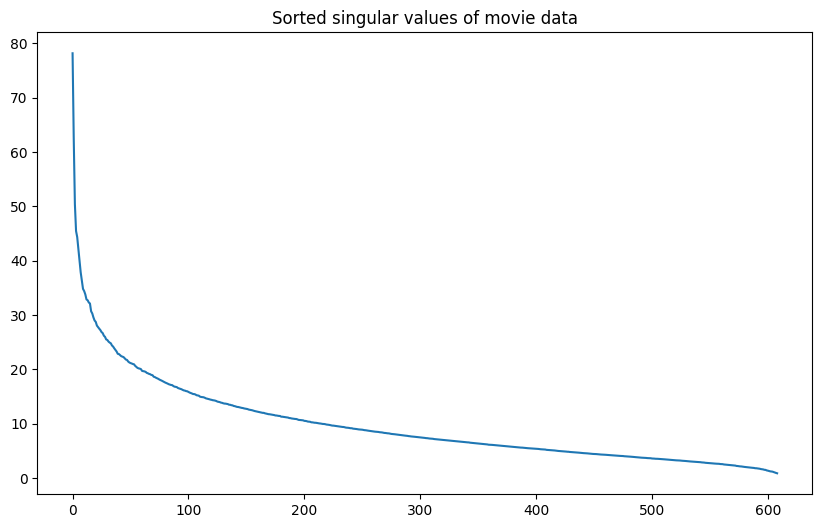

In [209]:
################################
# Minimal rank choice of a matrix
################################
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt


rank = min(sparse_data_coo.shape) - 1

# where r are the singular values
u, singular_values, vh = svds(sparse_data_csr, k = rank)

# sort singular values
singular_values = sorted(singular_values, reverse=True)

# Plot singular values
plt.figure(figsize = (10,6))
plt.plot(singular_values)
plt.title('Sorted singular values of movie data')
plt.show()


In [167]:
# Obtain the singular values representing 90% of total 
total = sum(singular_values)
cum_sum = 0
rank_emp = 0
for singular_value in singular_values:
    cum_sum += singular_value
    if cum_sum < 0.9 * total:
        rank_emp += 1
    else:
        break

rank_emp

433

In [155]:
# Check for significance difference between the gaps
import numpy as np
singular_diff = np.diff(singular_values)


In [ ]:
#######################
# Singular Value Projection
########################
import numpy as np
from scipy.sparse import find

y = data['rating']
# unique_movies = sparse_data_csr.shape[0]
# unique_users = sparse_data_csr.shape[1]
# s_ratings = len(y)

def rmse(y, x_pred):
    rmse = np.sqrt((y - x_pred)^2 / len(y))
    return rmse

def residual_calc(x_pred, y):
    residuals = 0

    # Retrieve the non-zero elements in the sparse matrix
    rows, cols, _ = find(x_pred)
    residuals = y - x_pred[rows, cols]

    # # Update with the resdiuals
    # x_pred  = x_pred + residuals
    return residuals

def update_data(x_pred, residuals):
    x_pred = x_pred + residuals
    return x_pred

def svd(x_pred, rank):
    # If full_matrices true, u and v have the shapes (..., M,M) and (..., N,N)
    # u, s, v = np.linalg.svd(x_pred, full_matrices = False)
    u, s, v = np.linalg.svd(x_pred, k = rank)
    
    # Perform the hard thresholding
    x_pred = u @ np.diag(s) @ v 
    return x_pred

In [ ]:
def svp(X, rank, eps):
    # initialize parameters
    rmse = []
    best_rmse = 0
    # residual = 0

    rows, cols, y = find(X)
    x_pred = np.zeros(X.shape)
    best_x_pred = np.copy(x_pred)


    stopping_criterion = False

    while not stopping_criterion:
        residual = residual_calc(x_pred, y) 
        x_pred = update_data(x_pred, residual)
        x_pred = svd(x_pred, rank = rank)

        #residual = residual_calc(x_pred, y)

        rmse_current = rmse(y, x_pred)
        rmse.append(rmse_current)

        if rmse_current > rmse[-2] - eps:
            convergence = True
        elif rmse_current > rmse[-2]:
            convergence = True
        
        if rmse_current < rmse[-2]:
            best_rmse = rmse_current
            best_x_pred = x_pred

        print(f'\rIteration {len(rmse)}, RMSE: {rmse_current}', end='')
    
    return best_x_pred, rmse

x_pred, rmse = svp(sparse_data_csr, rank = 8, eps = 0.01)



ValueError: operands could not be broadcast together with shapes (100836,) (0,) 

In [247]:
rows, columns, ratings = find(np.zeros(sparse_data_csr.shape))

In [248]:
ratings

array([], dtype=float64)

In [255]:
rows, columns, ratings_true = find((sparse_data_csr))

In [256]:
test = ratings_true - ratings

ValueError: operands could not be broadcast together with shapes (100836,) (0,) 

In [254]:
ratings_true

array([], dtype=float64)